In [1]:
import numpy as np
import pandas as pd
import datetime
import pickle
import re

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set()

# 統計モデル
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# 線形回帰
from sklearn import linear_model

# 誤差の評価
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# ワーニングを表示させない
import warnings
warnings.filterwarnings('ignore')

In [2]:
inputDir = "/home/onimem/work/Open_world/NBA/Graph"
outputDir = "/home/onimem/work/Open_world/NBA/Model"

# primary attribute
PA = 'Tm'
# primary attribute contents
PAC = ['ATL', 'BRK', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHO', 'PHI', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']

# 誤差辞書
error = {}
error['new node'] = {}
error['new node']['true'] = []
error['new node']['pred'] = []
ERROR_NN_T = error['new node']['true']
ERROR_NN_P = error['new node']['pred']

# 時系列グラフの読み込み
with open(inputDir + '/nba.graph', mode='rb') as f:
    graph = pickle.load(f)

# NULL attribute
YEAR = 1950
NAME = 'Curly Armstrong'
NULL_ATTRIBUTE = {}
for k in graph[YEAR]['nodes'][NAME].keys():
    NULL_ATTRIBUTE[k] = 'NULL'

In [3]:
def plot_history(history, x, y, title):
    plt.plot(history[x], history[y], marker=".", label=y, color='#1ea8b5')
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()
    
def plot_history2(history, x, y1, y2, title, ylabel):
    plt.plot(history[x], history[y1], marker=".", color='#1ea8b5', label=y1)
    plt.plot(history[x], history[y2], marker=".", color='#ce405f', label=y2)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [4]:
def is_unique(seq):
    return len(seq) == len(set(seq))

def new_node(y1nodes, y2nodes):
    if is_unique(y1nodes) and is_unique(y2nodes):
        newnodes = set(y2nodes) - set(y1nodes)
        return len(newnodes)
    else :
        print("error")
        exit()

def loss_node(y1nodes, y2nodes):
    if is_unique(y1nodes) and is_unique(y2nodes):
        lossnodes = set(y1nodes) - set(y2nodes)
        return len(lossnodes)
    else :
        print("error")
        exit()

In [5]:
def GroupByPA(years, graph):
    panodes = {}
    for pac in PAC:
        panodes[pac] = {}
        for year in range(years[0]-1, years[-1]+1):
            panodes[pac][year] = {}
            for name, attribute in graph[year]['nodes'].items():
                if attribute[PA] == pac:
                    panodes[pac][year][name] = graph[year]['nodes'][name]
    return panodes

def LinearRegression(train_year, new_nodes_train, years_all):
    
    # 訓練期間で学習
    X = pd.DataFrame(train_year)
    Y = pd.DataFrame(new_nodes_train)
    model = linear_model.LinearRegression()
    model.fit(X, Y)
    
    # 予測 (全ての年にモデルを適用)
    px = np.array(years_all)[:,np.newaxis] # sklearnの仕様のため二次元numpy配列に変換
    py = model.predict(px)
    py = py.reshape(-1).tolist()
    return py

In [6]:
def PredictNodeNum(years_all, train_year, test_year, graph, mode):
    
    # 結果格納用リスト
    true_ls = []
    pred_ls = []
    num_per_pac = {}
    
    # primary attributeでグルーピング ( return : panodes[pac][year][name] )
    panodes = GroupByPA(years_all, graph)
    
    # primary attribute ごとに予測
    for pac, nodes in panodes.items():
        # pac : primary attributeが取りうる一つの属性値
        # nodes[year][name] : (primary属性=pac)のノード集合

        nodes_all = [] # 期間全体 years_all, nodes_all
        nodes_train = [] # 訓練用 train_year, nodes_train

        if mode == 'new':
            for year in years_all:
                diff = new_node(nodes[year-1], nodes[year])
                nodes_all.append(diff)
            for year in train_year:
                diff = new_node(nodes[year-1], nodes[year])
                nodes_train.append(float(diff))        
        elif mode == 'loss':
            for year in years_all:
                diff = loss_node(nodes[year-1], nodes[year])
                nodes_all.append(diff)
            for year in train_year:
                diff = loss_node(nodes[year-1], nodes[year])
                nodes_train.append(float(diff))
        
        # 学習＆予測
        pred = LinearRegression(train_year, nodes_train, years_all)
            
        # 結果をプロット
        history = {'year':years_all, 'true':nodes_all, 'pred':pred}
        plot_history2(history, 'year', 'true', 'pred', title=pac, ylabel="#player")

        # テスト期間のみの予測数を四捨五入してから辞書に格納
        num_per_pac[pac] = list(map(lambda x: round(x), pred[len(train_year):]))
        
        # 誤差を記録
        for i in range(len(test_year)):
            true_ls.append(nodes_all[-1-i])
            pred_ls.append(list(pred)[-1-i])
        
    return num_per_pac, true_ls, pred_ls

In [7]:
# ひとまず年齢順に消す(本来出現と消失は交互に繰り返されるべきだが、ここはH=1として実装)
def DeleteNode(graph, loss_per_pac, test_year):
    result = []
    for pac, loss_num_list in loss_per_pac.items():
        for i in range(len(loss_num_list)):
            year = test_year[i] - 1 # 一つ前のタイムステップから消すノードを選択する
            loss_num = loss_num_list[i]
            age_dic = {}
            for name, attribute in graph[year]['nodes'].items():
                if attribute[PA] == pac:
                    age_dic[name] = int(attribute['Age'])
            loss_name_list = []
            for name, age in sorted(age_dic.items(), key=lambda x: -x[1]):
                if len(loss_name_list) < loss_num:
                    loss_name_list.append(name)
                    #print(year, pac, loss_num, age, name)
            result.extend(loss_name_list)
    return result

In [8]:
# primary属性に基づく部分リンクを張る
def AddPortLink(node1, train_year, graph, U_node):
    port_edge = set()
    pac1 = node1.split('_')[1]
    for node2, attribute in graph[train_year[-1]]['nodes'].items():
            if attribute[PA] == pac1:
                port_edge.add((node1, node2))
    for node2 in U_node:
        if node2.split('_')[0] == 'NEW':
            pac2 = node2.split('_')[1]
            if pac1 == pac2 and node1 != node2:
                port_edge.add((node1, node2))
    return port_edge

In [9]:
def GeneratePortGraph(train_year, test_year, graph, new_per_pac):
    
    # 全てのタイムステップで観測されるノード集合
    U_node = set()
    for year in train_year:
        for name, _ in graph[year]['nodes'].items():
            U_node.add(name)
    for i in range(len(test_year)):
        year = test_year[i]
        for pac, new_num_list in new_per_pac.items():
            for j in range(new_num_list[i]):
                U_node.add('NEW_' + pac + '_' + str(year) + '_' + str(j))
    
    # 全てのタイムステップで観測されるエッジ集合(将来のものについては部分リンク)
    U_edge = set()
    for year in train_year:
        for edge in graph[year]['edges']['team']:
            U_edge.add(edge)
    for node in U_node:
        if node.split('_')[0] == 'NEW':
            # 部分リンクを張る
            port_edge = AddPortLink(node, train_year, graph, U_node)
            U_edge = U_edge.union(port_edge)
    
    # 過去Mステップでの全てのノードに属性を割り当てる。ノードが存在しない年はNULL値。
    port_graph = {}    
    for year in train_year:
        port_graph[year] = {}
        port_graph[year]['nodes'] = {}
        port_graph[year]['edges'] = {}
        port_graph[year]['edges']['team'] = list(U_edge)
        for name in U_node:
            port_graph[year]['nodes'][name] = {}
            if name in graph[year]['nodes'].keys():
                port_graph[year]['nodes'][name] = graph[year]['nodes'][name]
            else:
                port_graph[year]['nodes'][name] = NULL_ATTRIBUTE
    return port_graph

In [10]:
def PrintNode(train_year, port_graph):
    YEAR = list(port_graph.keys())[0] # 何でも良い
    for name in port_graph[YEAR]['nodes'].keys():
        for year in train_year:
            print(name, year, port_graph[year]['nodes'][name])

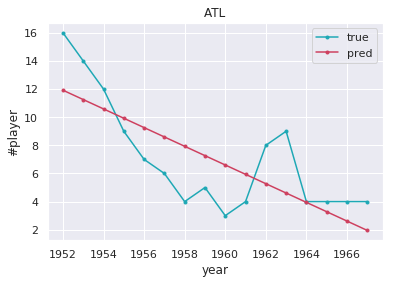

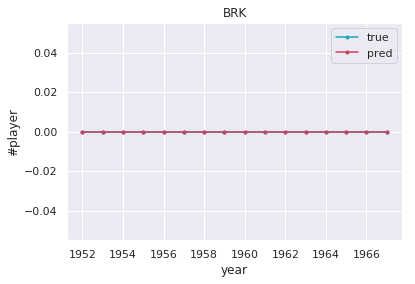

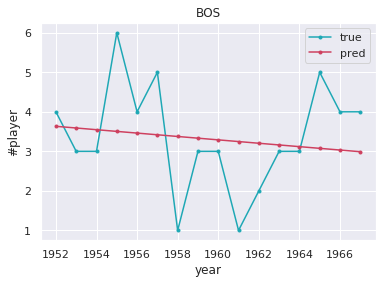

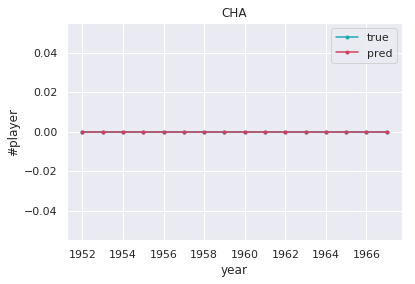

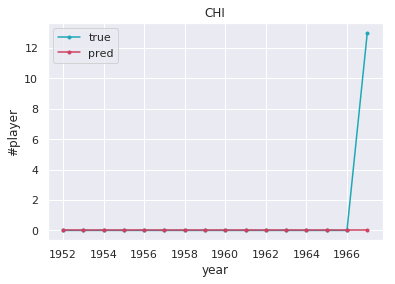

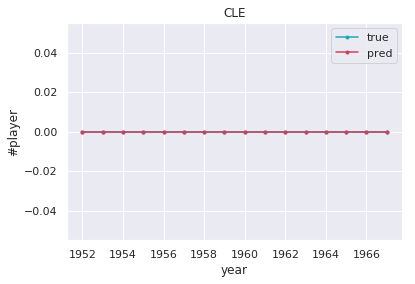

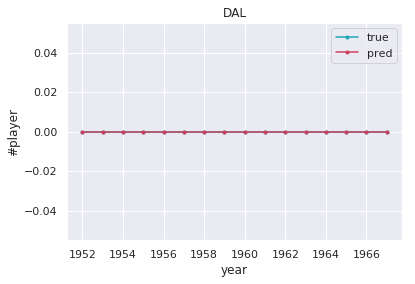

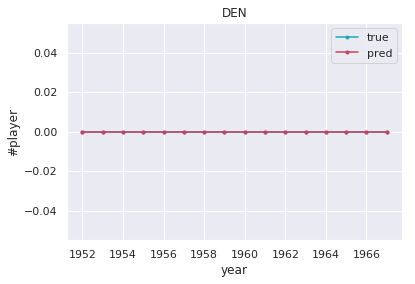

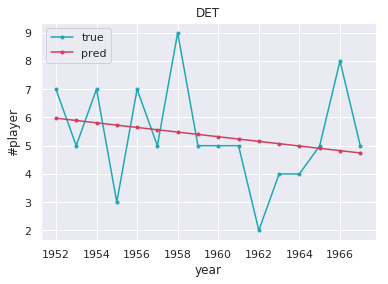

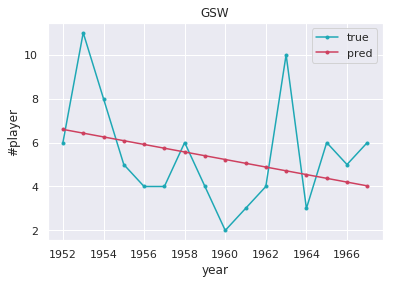

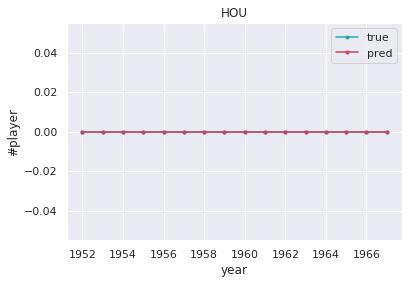

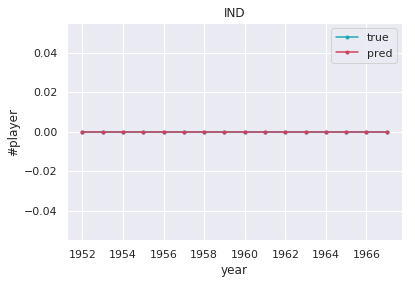

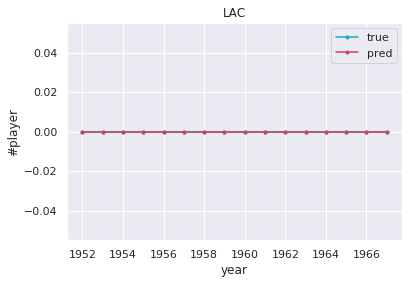

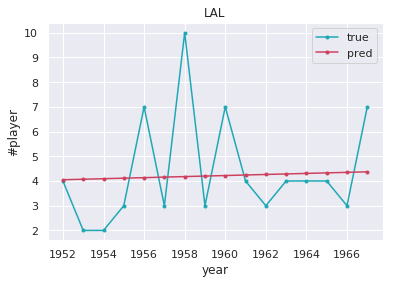

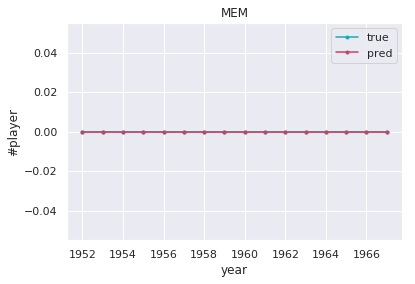

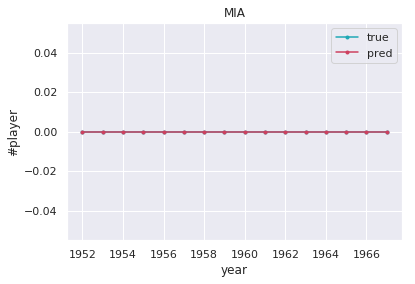

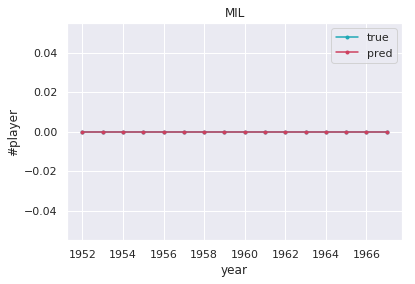

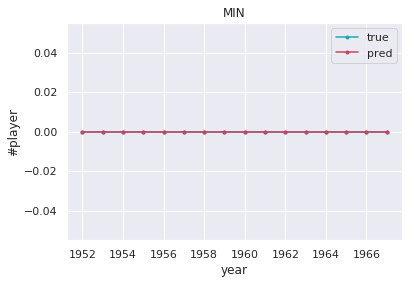

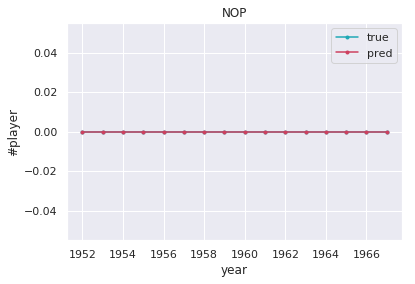

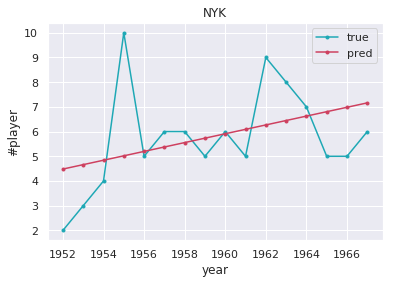

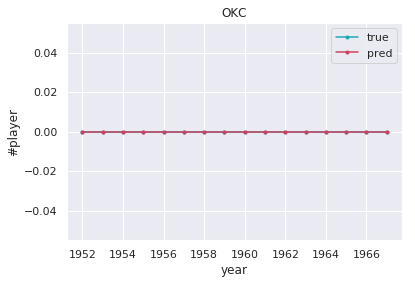

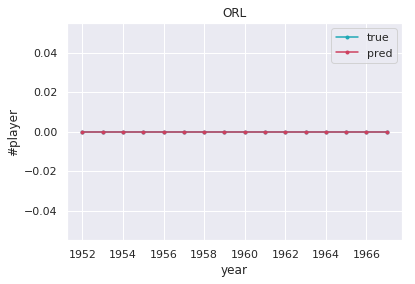

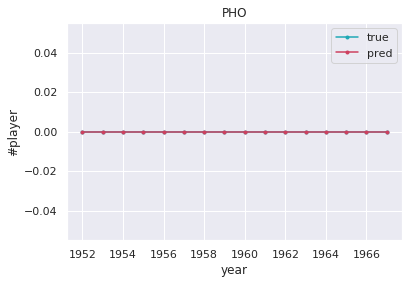

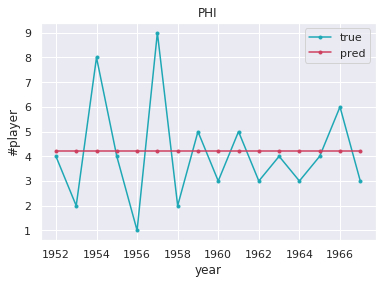

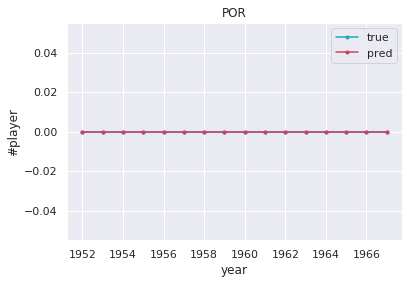

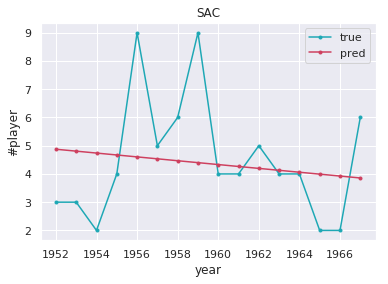

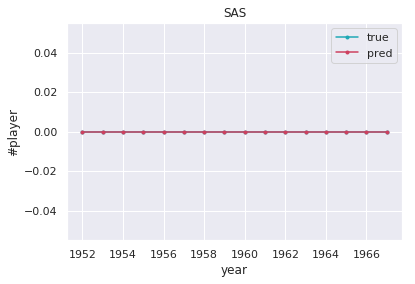

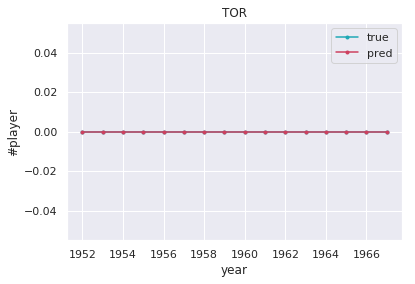

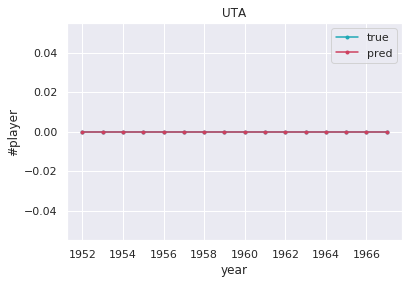

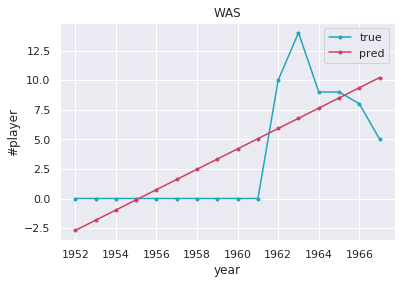

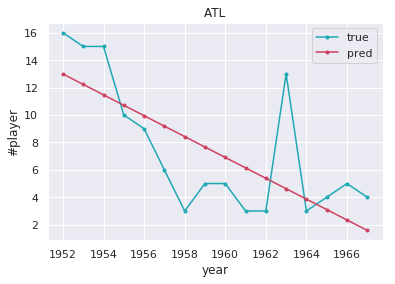

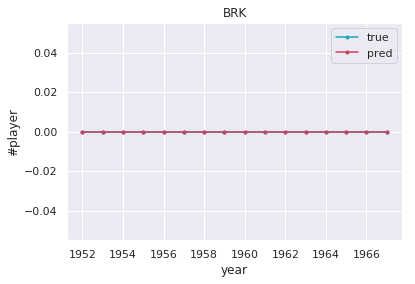

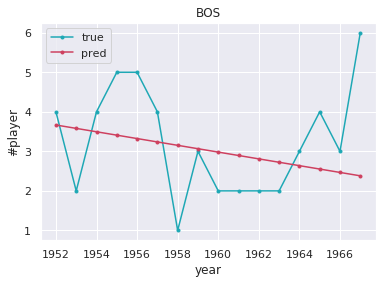

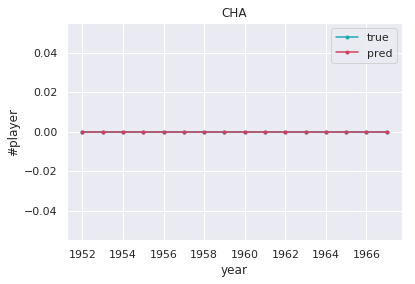

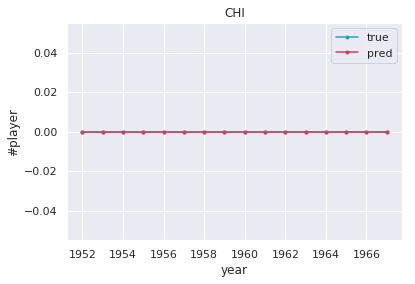

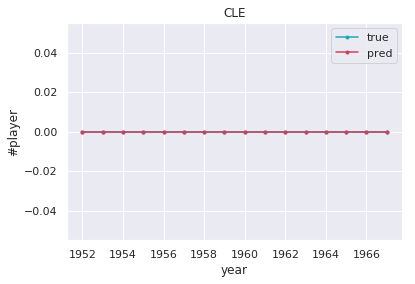

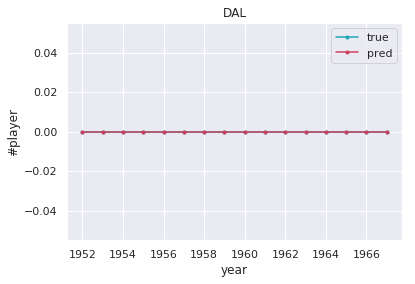

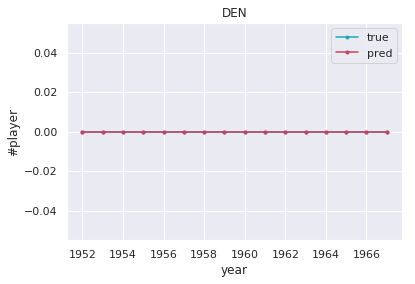

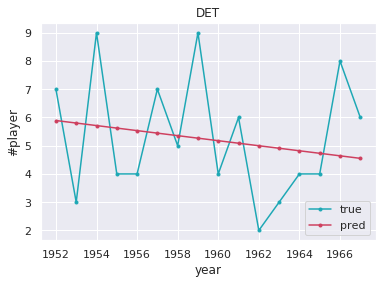

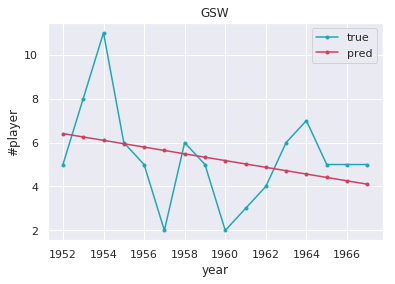

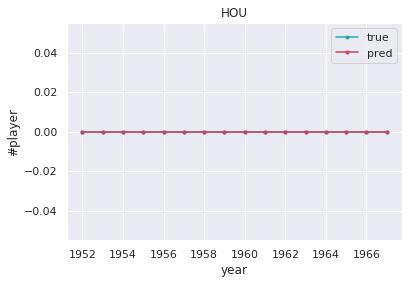

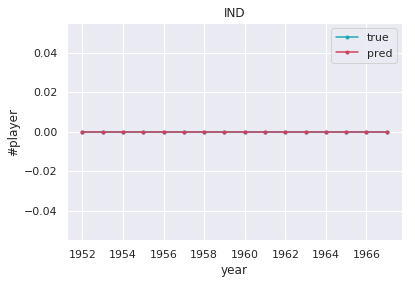

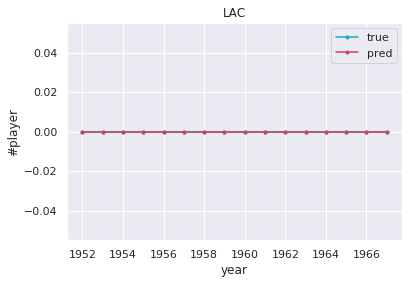

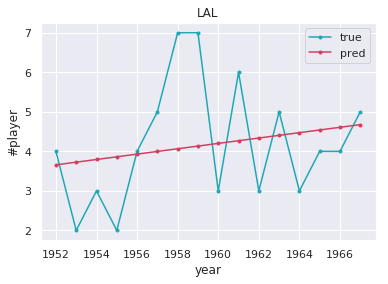

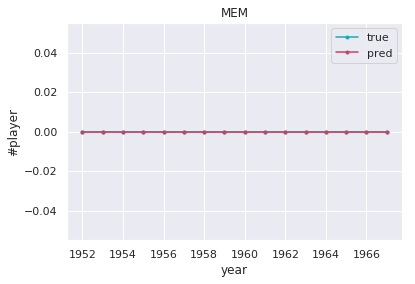

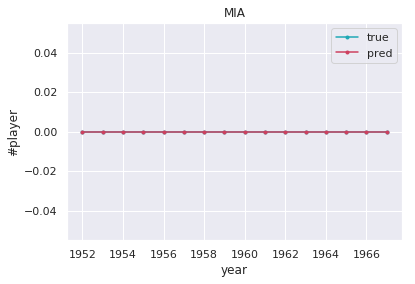

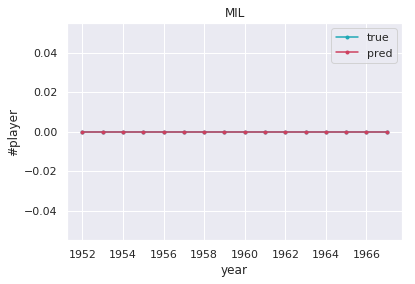

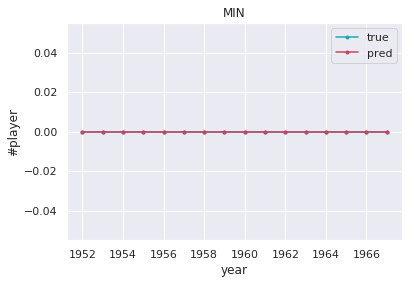

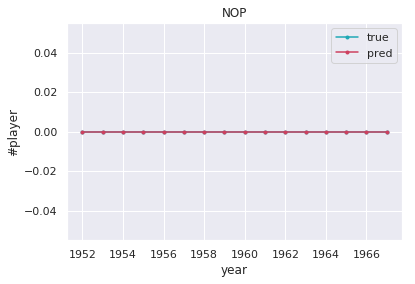

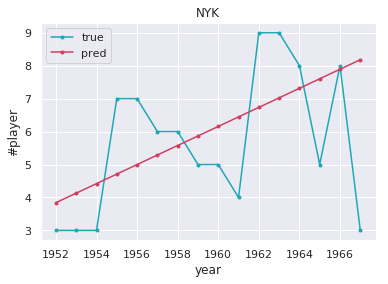

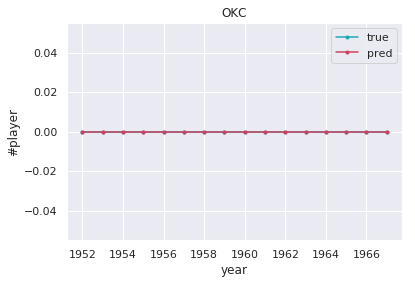

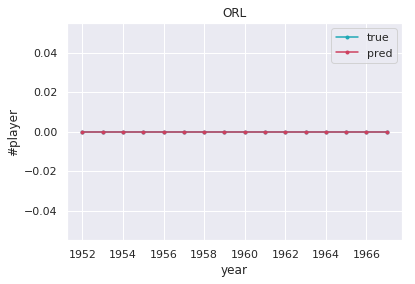

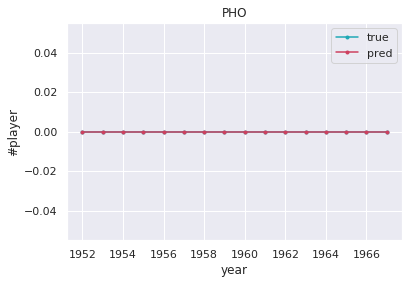

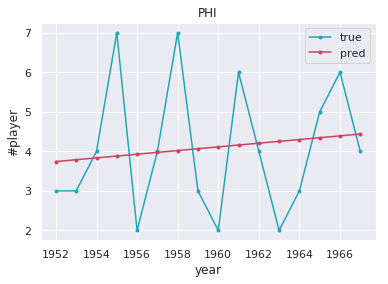

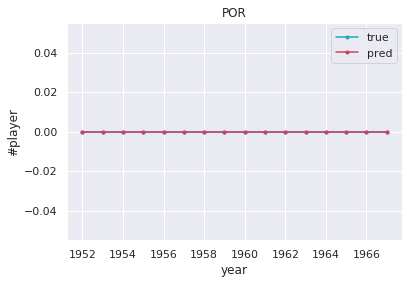

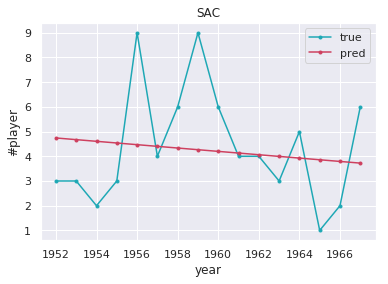

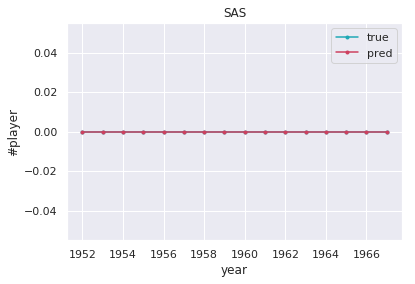

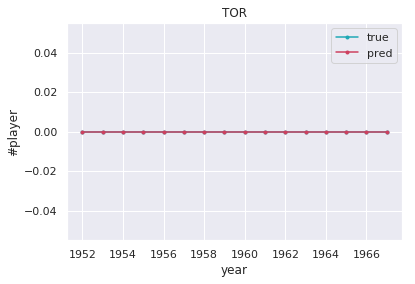

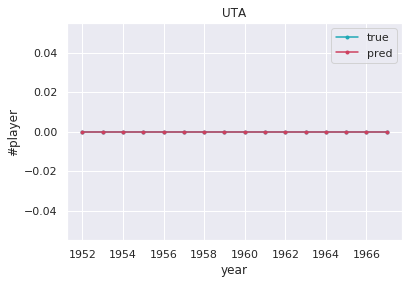

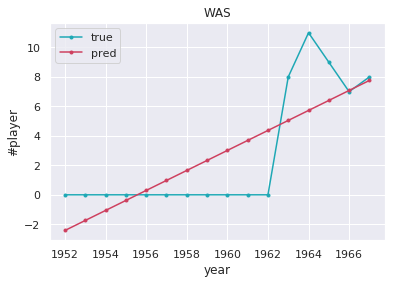

Pat Dunn 1952 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Pat Dunn 1953 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Pat Dunn 1954 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Pat Dunn 1955 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Pat Dunn 1956 {'PF': 'NULL', 'FT': 'NULL', '

Mo Mahoney 1953 {'PF': 7.0, 'FT': 4.0, 'AST': 1.0, '2P': 4.0, '2PA': 10.0, 'Pos': 'F', 'FGA': 10.0, 'G': 6.0, 'FG': 4.0, 'weight': 92.0, 'Age': 25.0, 'Tm': 'BOS', 'height': 188.0, 'PTS': 12.0, 'FTA': 5.0}
Mo Mahoney 1954 {'PF': 0.0, 'FT': 0.0, 'AST': 1.0, '2P': 0.0, '2PA': 2.0, 'Pos': 'F', 'FGA': 2.0, 'G': 2.0, 'FG': 0.0, 'weight': 92.0, 'Age': 26.0, 'Tm': 'BLB', 'height': 188.0, 'PTS': 0.0, 'FTA': 0.0}
Mo Mahoney 1955 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Mo Mahoney 1956 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Mo Mahoney 1957 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 

Ed Smith 1966 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Bailey Howell 1952 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Bailey Howell 1953 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Bailey Howell 1954 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Bailey Howell 1955 {'PF': 'NU

Phil Jordon 1962 {'PF': 258.0, 'FT': 96.0, 'AST': 156.0, '2P': 403.0, '2PA': 1028.0, 'Pos': 'C', 'FGA': 1028.0, 'G': 76.0, 'FG': 403.0, 'weight': 92.0, 'Age': 28.0, 'Tm': 'NYK', 'height': 208.0, 'PTS': 902.0, 'FTA': 168.0}
Phil Jordon 1963 {'PF': 172.0, 'FT': 56.0, 'AST': 103.0, '2P': 211.0, '2PA': 527.0, 'Pos': 'C', 'FGA': 527.0, 'G': 73.0, 'FG': 211.0, 'weight': 92.0, 'Age': 29.0, 'Tm': 'ATL', 'height': 208.0, 'PTS': 478.0, 'FTA': 101.0}
Phil Jordon 1964 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Phil Jordon 1965 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Phil Jordon 1966 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL

NEW_WAS_1967_9 1956 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
NEW_WAS_1967_9 1957 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
NEW_WAS_1967_9 1958 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
NEW_WAS_1967_9 1959 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
NEW_WAS_1967_9 1960 

Barry Clemens 1957 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Barry Clemens 1958 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Barry Clemens 1959 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Barry Clemens 1960 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
Barry Clemens 1961 {'PF'

John Windsor 1954 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
John Windsor 1955 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
John Windsor 1956 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
John Windsor 1957 {'PF': 'NULL', 'FT': 'NULL', 'AST': 'NULL', '2P': 'NULL', '2PA': 'NULL', 'Pos': 'NULL', 'FGA': 'NULL', 'G': 'NULL', 'FG': 'NULL', 'weight': 'NULL', 'Age': 'NULL', 'Tm': 'NULL', 'height': 'NULL', 'PTS': 'NULL', 'FTA': 'NULL'}
John Windsor 1958 {'PF': 'NU

In [11]:
# 過去Mステップから将来Hステップを予測する
M = 15
H = 1
#years = [i for i in range(1952, 2018-(M+H-1))] 
years = [i for i in range(1952, 1968-(M+H-1))]

for year in years:
    # train_year:Mステップ, test_year:Hステップ, years_all:M+Hステップ
    train_year = [(year+m) for m in range(M)]
    test_year = [(train_year[-1]+h+1) for h in range(H)]
    years_all = train_year.copy()
    years_all.extend(test_year)
    
    # primary属性ごとに将来出現するノード数を予測
    new_per_pac, true_ls, pred_ls = PredictNodeNum(years_all, train_year, test_year, graph, 'new')    
    ERROR_NN_T.extend(true_ls)
    ERROR_NN_P.extend(pred_ls)
    
    # primary属性ごとに将来消失するノード数を予測
    loss_per_pac, true_ls, pred_ls = PredictNodeNum(years_all, train_year, test_year, graph, 'loss')    
    ERROR_NN_T.extend(true_ls)
    ERROR_NN_P.extend(pred_ls)
    
    # 消失するノードの決定 ひとまず省略 (将来Hステップではevolving graphとする)
    # delete_name = DeleteNode(graph, loss_per_pac, test_year)
    
    # M+Hステップで観測されたノードを全てを含む,Mステップの時系列部分グラフを構築。
    # 厳密に言うと将来については観測されたものではなく出現を予測されたノード。
    port_graph = GeneratePortGraph(train_year, test_year, graph, new_per_pac)
    
    # 部分グラフのノード属性確認用のprint関数
    PrintNode(train_year, port_graph)
    
    
    #print(new_per_pac)
    #print(loss_per_pac)
    #print(delete_name)
print("NodeNumPredError MAE", mean_absolute_error(ERROR_NN_T, ERROR_NN_P))
print("NodeNumPredError MSE", mean_squared_error(ERROR_NN_T, ERROR_NN_P))
print("NodeNumPredError RMSE", np.sqrt(mean_squared_error(ERROR_NN_T, ERROR_NN_P)))    